In [2]:
import sys
from pathlib import Path
import os

# Add the parent directory of this script to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from settings import *
from simulation import *

In [2]:
import torch
import numpy as np

# Load a validation set and check video

val_data = np.load('../data/validation_data_11.npz')
val_videos = torch.Tensor(val_data['vids'])
val_displacements = torch.Tensor(val_data['disp'])
val_labels = torch.Tensor(val_data['labels'])
#val_labels = val_labels / np.array([D_max_normalization, D_max_normalization, 1])

In [3]:
from simulation import play_video

play_video(val_videos[0])

vmin: -0.15095235407352448 vmax: 0.8706678152084351 mean: 0.09


In [2]:
from simulation import *

# Image parameters
N = 1 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 11,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": -1, # -1 for no noise
    "gaussian_noise": False,
    "trajectory_unit" : 1200,
    "D_min": 0.05, # um^2/s
    "D_max": 6, 
    "angle_max": np.pi,
    "D_max_norm": 6, # factor to divide by for normalization
}

np.random.seed(143)

#videos, displacements, labels = create_multi_state_dataset_w_features(N, T, image_props, dt=0.001, binding=True) 
videos, displacements, labels = create_training_set_w_features(N, T, image_props) 
#videos, _, labels = create_training_set_w_features(N, T, image_props)

In [3]:
from simulation import *

# Image parameters
N = 1 # number of particles to simulate
nPosPerFrame = 10 
nFrames = 30
T = nFrames * nPosPerFrame
# values from Real data
background_mean,background_sigma = 1420, 290
part_mean, part_std = 6000 - background_mean,500

image_props = {
    "n_pos_per_frame": nPosPerFrame,
    "frames": nFrames,
    "particle_intensity": [
        part_mean,
        part_std,
    ],  # Mean and standard deviation of the particle intensity
    "NA": 1.46,  # Numerical aperture
    "wavelength": 500e-9,  # Wavelength
    "psf_division_factor": 1.3,  
    "resolution": 100e-9,  # Camera resolution or effective resolution, aka pixelsize
    "output_size": 11,
    "upsampling_factor": 5,
    "background_intensity": [
        background_mean,
        background_sigma,
    ],  # Standard deviation of background intensity within a video
    "poisson_noise": 100, # -1 for no noise
    "gaussian_noise": True,
    "trajectory_unit" : 1200,
    "D_min": 0.05, # um^2/s
    "D_max": 6, 
    "angle_max": np.pi,
    "D_max_norm": 6, # factor to divide by for normalization
}

np.random.seed(143)

#videos, displacements, labels = create_multi_state_dataset_w_features(N, T, image_props, dt=0.001, binding=True) 
videos2, displacements2, labels2 = create_training_set_w_features(N, T, image_props) 
#videos, _, labels = create_training_set_w_features(N, T, image_props)

In [4]:
i = np.random.randint(0, videos.shape[0])

play_video(videos[i])#  save_path='./max_diffusion_12.gif')

vmin: -0.23203285038471222 vmax: 0.39965924620628357 mean: -0.21


In [5]:
play_video(videos2[0])#, save_path='./ex_no_noise_143.gif')

vmin: -0.1443272829055786 vmax: 0.7191979885101318 mean: 0.09


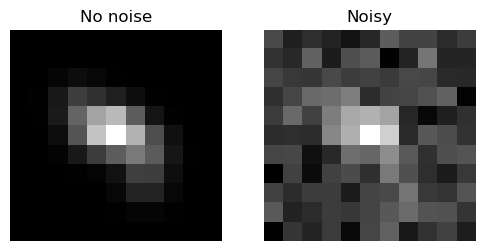

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,3))

ax1.imshow(videos[0][0], cmap='gray')
ax1.axis('off')
ax1.set_title('No noise')

ax2.imshow(videos2[0][0], cmap='gray')
ax2.axis('off')
ax2.set_title('Noisy')

plt.show()

In [9]:
def plot_trajectories_item_color_coded(ax, trajectories, colors, N_PARTICLES_PLOTTED, FOV=0, prefix=''):
    starts = [] 
    for i in range(min(len(trajectories), N_PARTICLES_PLOTTED)):
        P = np.stack(trajectories[i])
        x, y = P[:,0], P[:,1]
        starts.append(P[0])
        ax.plot(x, y, color=colors[i], label=f"P{i}")
    starts = np.vstack(starts)
    ax.scatter(starts[:,0], starts[:,1], s=6, facecolors='none', edgecolors='blue', linewidths=1.5)
    #ax.set_xlim((0,FOV[0]))
    #ax.set_ylim((0,FOV[1])) 
    ax.set_title("Subtrajectories for frame generation")
    #ax.set_title(f"{prefix} Motion Trajectories (first {N_PARTICLES_PLOTTED})")

In [ ]:
np.random.seed(143)

props = generate_diffusion_props(N, image_props['D_min'], image_props['D_max'], image_props['angle_max'], is_isotropic=False)
p1, p2, theta = props[:,0], props[:,1], props[:,2]

# if fov is None:
#     fov = np.array([0,0])
    
# Create trajectories
pos = create_trajectories(p1, p2, theta, N, T, dt=0.001)

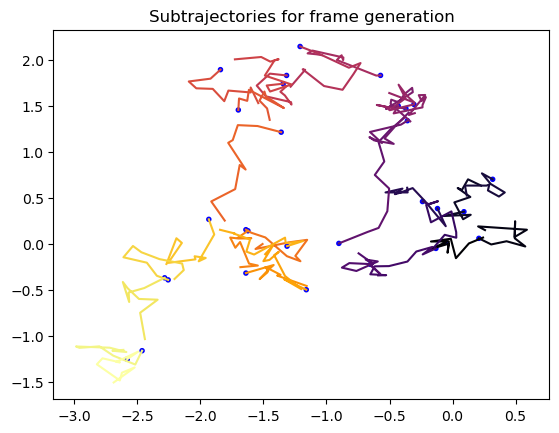

In [15]:
fig, ax = plt.subplots()

# Reshape the trajectories to get sub-segments
frames = pos.reshape(-1, nPosPerFrame, 2)

cmap = plt.colormaps['inferno'].resampled(T//nPosPerFrame)
colors = cmap(np.linspace(0, 1, T//nPosPerFrame)) 

plot_trajectories_item_color_coded(ax, frames, colors, T//nPosPerFrame)

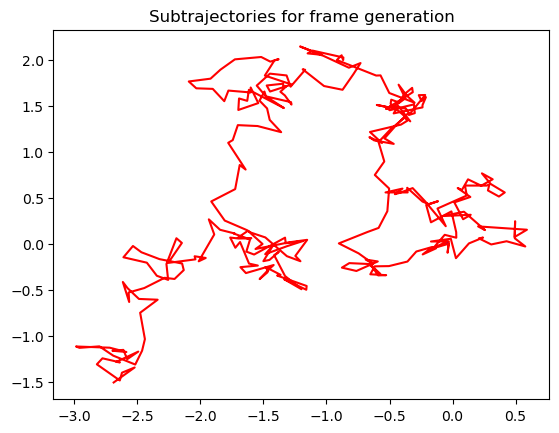

In [16]:
fig, ax = plt.subplots()

plot_trajectories_item_color_coded(ax, pos, ['r'], 1)

## Display for different noise levels

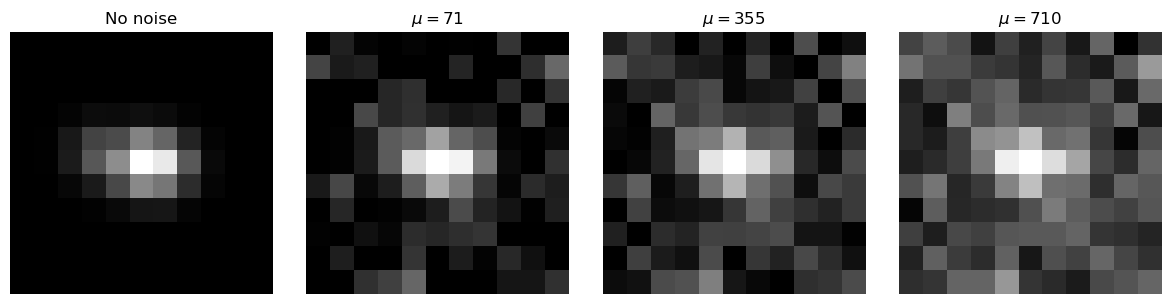

In [15]:
import matplotlib.pyplot as plt

image_props = SINGLE_STATE_PROPS

NOISE_LEVELS = [0, 1/20, 1/4, 1/2]

images = []
for i, noise in enumerate(NOISE_LEVELS):
    if i == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
    image_props['background_intensity'][0] = noise * background_mean
    
    # Genereate videos
    np.random.seed(2)
    videos, displacements, labels = create_training_set_w_features(1, T, image_props)
    
    images.append(videos[0][0])
    
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, cmap="gray")
    if i == 0:
        ax.set_title('No noise')
    else:
        ax.set_title(rf'$\mu = {int(NOISE_LEVELS[i] * background_mean)}$')
    ax.axis("off")

#fig.supxlabel('Background Gaussian Noise Variation ')
fig.tight_layout()
plt.show()

In [63]:
np.stack(images).min()

np.float32(-0.04217253)

In [19]:
(images[-1] - images[-2]).mean()

np.float32(3.8484402e-12)

## Display for different PSF sizes

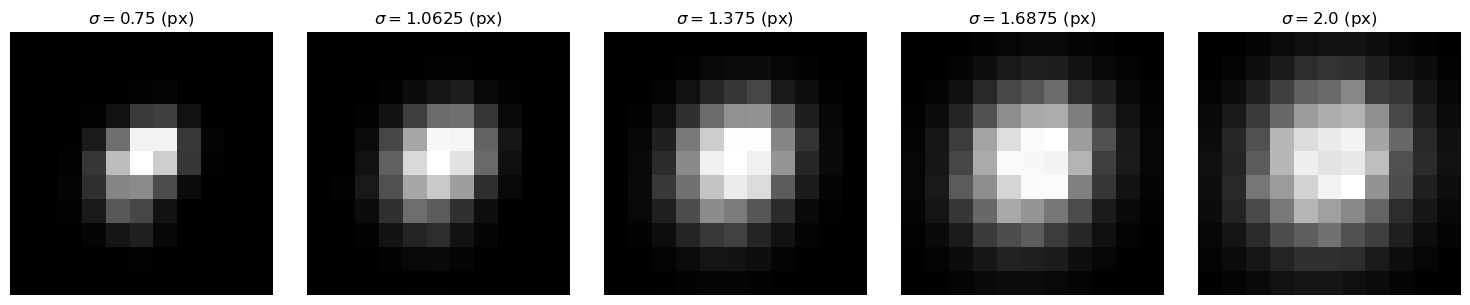

In [16]:
image_props = SINGLE_STATE_PROPS
image_props['gaussian_noise'] = False

# Choose sigmas and calculate required aperture
sigmas = np.linspace(0.75, 2, num=5)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

images = []
for i, aperture in enumerate(apertures):
    # Update with new division factor (used for changing gaussian_sigma)  
    image_props['NA'] = aperture
    
    np.random.seed(1)
    videos, displacements, labels = create_training_set_w_features(1, T, image_props)
    
    images.append(videos[0][0])
    
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img, cmap="gray")
    ax.set_title(rf'$\sigma = {sigmas[i]}$ (px)')
    ax.axis("off")

#fig.supxlabel('PSF Size Variation ')
fig.tight_layout()
plt.show()

## Matrix of PSF sizes and noise

In [ ]:
image_props = SINGLE_STATE_PROPS
image_props['gaussian_noise'] = False

# Choose sigmas and calculate required aperture
sigmas = np.linspace(0.75, 2, num=3)
apertures =  0.51 * image_props['wavelength'] / image_props['resolution'] / 2.355 / sigmas

NOISE_LEVELS = np.array([0, 1/10, 1/2]) * background_mean

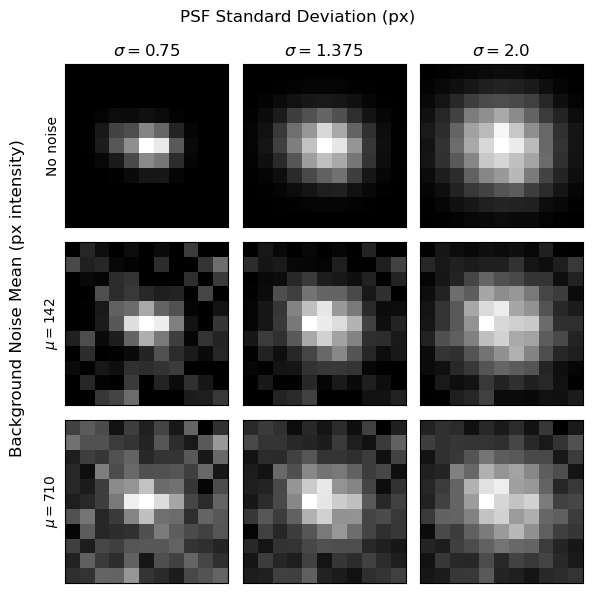

In [32]:
fig, axs = plt.subplots(3,3, figsize=(6,6))

# Loop for noise
for i in range(3):
    if i == 0:
        image_props['gaussian_noise'] = False
    else:
        image_props['gaussian_noise'] = True
        
    image_props['background_intensity'][0] = NOISE_LEVELS[i]        
    # Loop for psf
    for j in range(3):
        image_props['NA'] = apertures[j]
        
        np.random.seed(2)
        videos, displacements, labels = create_training_set_w_features(1, T, image_props)
        
        if j == 0:
            if i == 0:
                axs[i,j].set_ylabel('No noise')
            else:
                axs[i,j].set_ylabel(rf'$\mu = {int(NOISE_LEVELS[i])}$')
                
        if i == 0:
            axs[i,j].set_title(rf'$\sigma = {sigmas[j]}$')
        
        axs[i,j].imshow(videos[0][0], cmap='gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.supylabel('Background Noise Mean (px intensity)')
fig.suptitle('PSF Standard Deviation (px)')
fig.tight_layout()
plt.show()